In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Source

In [2]:
from pathlib import Path
data_path = Path('/content/drive/MyDrive/FacialAge/Data')
weight_path = Path('/content/drive/MyDrive/FacialAge/WeightH5')
model_path = Path('/content/drive/MyDrive/FacialAge/Model_V3')

# Preprocessing

## Parameter

In [3]:
width = height = 224
img_size = (width, height)
img_shape = img_size + (3, )
batch_size = 32 
initial_epochs = 50
fine_tune_epochs = 50
seed = 10
learning_rate = 1e-4
results = {}

## Load data
70% train, 15% test, 15% val

### Train Dataset

In [4]:
from tensorflow.data.experimental import cardinality
from tensorflow.keras.preprocessing import image_dataset_from_directory
train_ds = image_dataset_from_directory(
                                      data_path,
                                      labels="inferred",
                                      label_mode="int",
                                      class_names=None,
                                      seed=seed,
                                      image_size=img_size,
                                      smart_resize=True,
                                      batch_size=batch_size)
temp_ds = train_ds
train_batches = cardinality(train_ds)

Found 9778 files belonging to 99 classes.


In [5]:
class_names = train_ds.class_names
num_class = len(class_names)
print(num_class,' : ', class_names)

99  :  ['001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016', '017', '018', '019', '020', '021', '022', '023', '024', '025', '026', '027', '028', '029', '030', '031', '032', '033', '034', '035', '036', '037', '038', '039', '040', '041', '042', '043', '044', '045', '046', '047', '048', '049', '050', '051', '052', '053', '054', '055', '056', '057', '058', '059', '060', '061', '062', '063', '064', '065', '066', '067', '068', '069', '070', '071', '072', '073', '074', '075', '076', '077', '078', '079', '080', '081', '082', '083', '084', '085', '086', '087', '088', '089', '090', '091', '092', '093', '095', '096', '099', '100', '101', '110']


### Test Dataset

In [6]:
test_ds = train_ds.take(train_batches // 20 * 3)
train_ds = train_ds.skip(train_batches // 20 * 3)

### Val Dataset

In [7]:
val_ds = train_ds.take(train_batches // 20 * 3)
train_ds = train_ds.skip(train_batches // 20 * 3)

## Data Visualization

### Overview

In [8]:
import os
import numpy as np
labels = []
files = []
for a in os.walk(data_path):
    labels = a[1]
    break
for a in os.walk(data_path):
    files.append(len(a[2]))
files.remove(0)
a = []
for i in range(99):
    a. append([int(labels[i]),files[i]]) 
num_class = len(labels)
num_files = sum(files)
a.sort()
a = np.array(a)

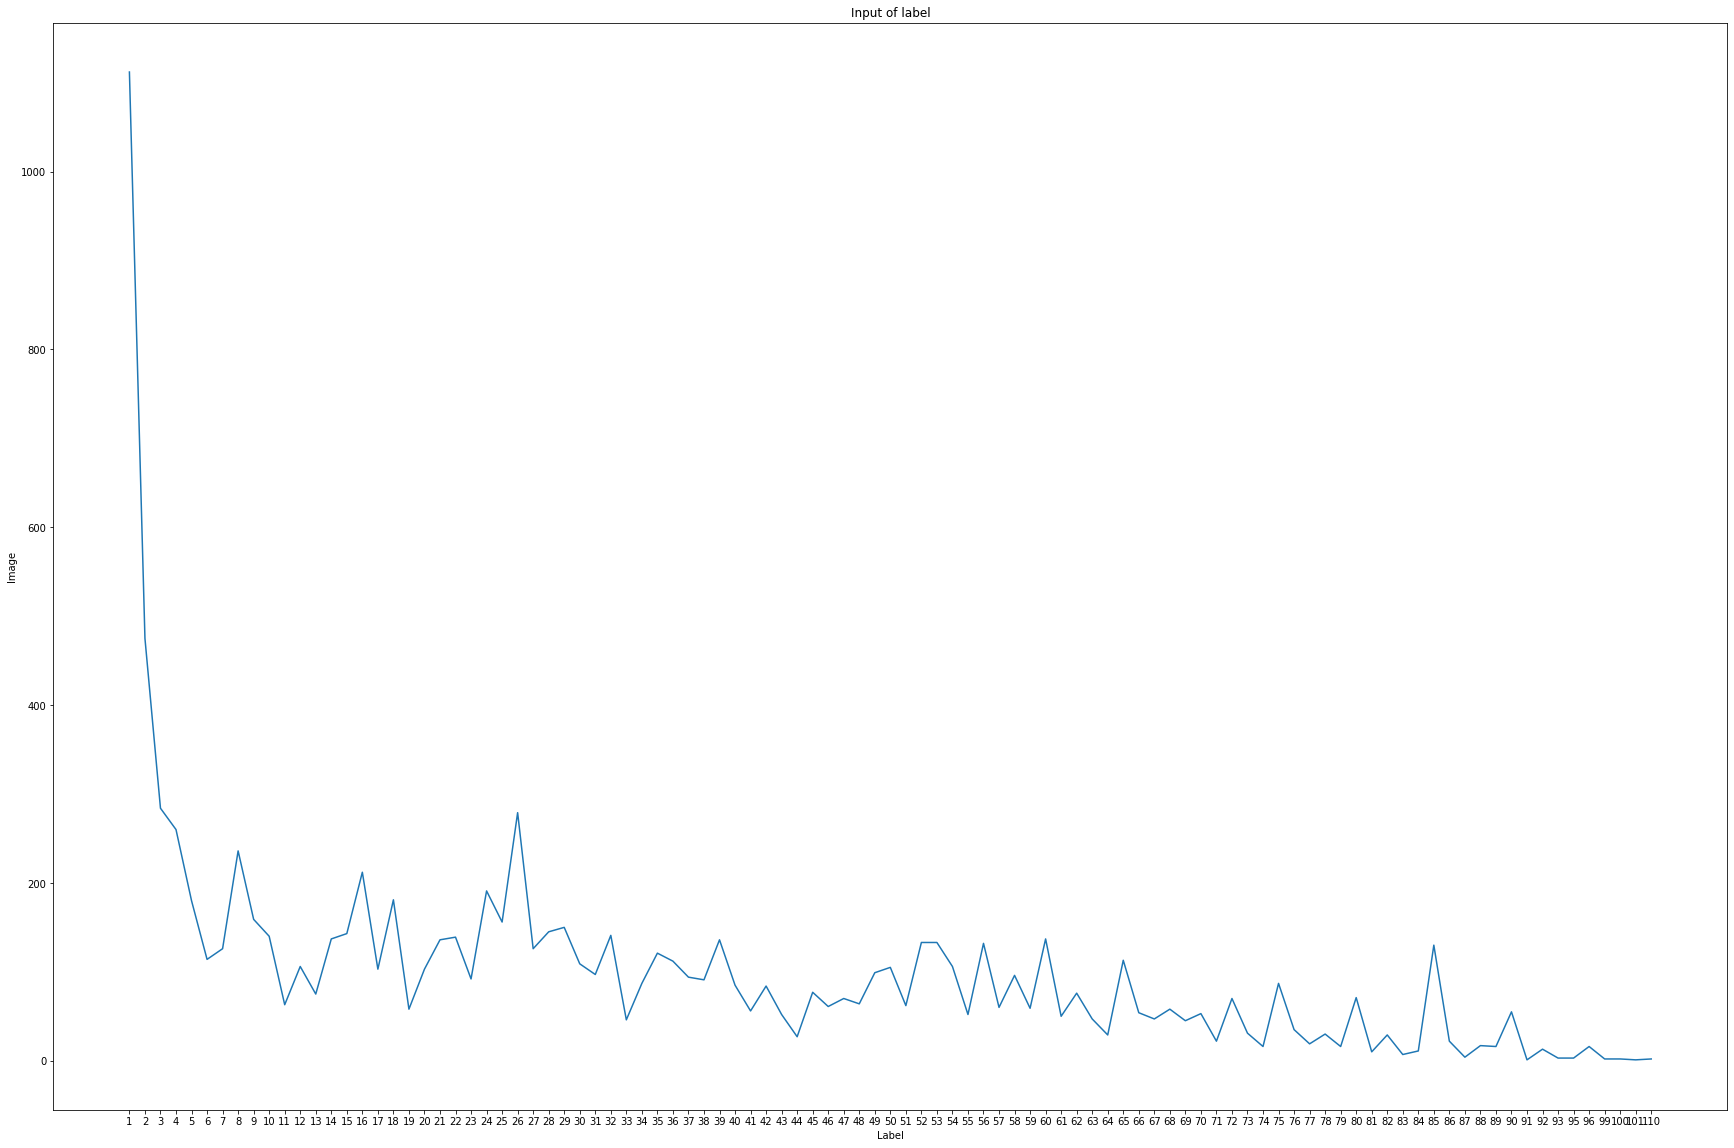

In [9]:
import matplotlib.pyplot as plt
X = a[:,0]
Y = a[:,1]
X_axis = np.arange(len(X))
plt.figure(figsize=(30,20))  
plt.plot(X_axis , Y, 0.4)
plt.xticks(X_axis, X)
plt.xlabel("Label")
plt.ylabel("Image")
plt.title("Input of label")
plt.show()

### Example

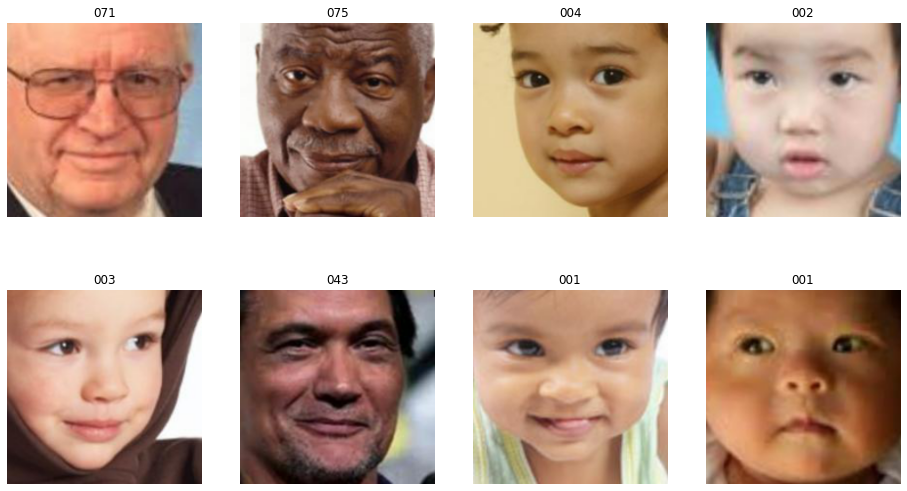

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,9))
images, labels = next(iter(temp_ds))
for i in range(8):
  ax = plt.subplot(2, 4, i + 1)
  plt.imshow(images[i].numpy().astype("uint8"))
  plt.title(temp_ds.class_names[labels[i]])
  plt.axis("off")

## Data augment

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom
data_augmentation = Sequential(
  [
    RandomFlip("horizontal", input_shape = img_shape),
    RandomRotation(0.1),
    RandomZoom(-0.1,0.1),
  ]
)

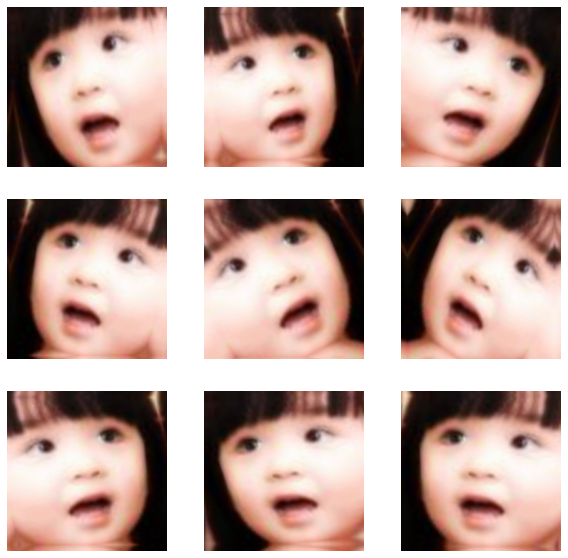

In [12]:
import tensorflow as tf
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Data Performance

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Call Back 

In [14]:
from keras.callbacks import Callback, ReduceLROnPlateau, EarlyStopping
from timeit import default_timer as timer

class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

early_stopping = EarlyStopping(
                                patience=5, # wait for 5 epochs
                                min_delta = 0.01, # if in 5 epochs the loss function doesn't inrease (for accuracy) 
                                               # or decrease (for val_loss) by 1%, then stop
                                verbose=1, # print the training epoch on which training was stopped
                                mode = 'min',
                                monitor='val_loss')

reduce_learning_rate = ReduceLROnPlateau(
                                    monitor="val_loss",
                                    patience=1, # if val_loss plateaus for 1 epochs such that it doesn't see 
                                                # an improvement of size = epsilon
                                    episilon= 0.01,
                                    factor=0.1,  # then we reduce the learning rate by a factor of 0.1
                                    cooldown = 4, # and we wait for 4 epochs before we restart again
                                    verbose=1)

time_callback = TimingCallback()

# Model 

## MobileNet V3L

### Base Model

In [15]:
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# download model MobileNet V3L
base_model_V3L = MobileNetV3Large(input_shape =  img_shape, 
                                 include_top = False, 
                                 weights = 'imagenet')
# Freeze the base model
base_model_V3L.trainable = False

17612800/17605208 [==============================] - 0s 0us/step


### Build Model

In [16]:
inputs = Input(shape=img_shape)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model_V3L(x, training=False)
x = Convolution2D(num_class, (1, 1), name='predictions')(x)
x = GlobalAveragePooling2D()(x)
outputs = Activation('softmax')(x)

# Final model
model_V3L = Model(inputs, outputs)
model_V3L.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss='sparse_categorical_crossentropy'
                  ,metrics=['sparse_categorical_crossentropy'])

In [17]:
model_V3L.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3large (Functional (None, 7, 7, 1280)        4226432   
_________________________________________________________________
predictions (Conv2D)         (None, 7, 7, 99)          126819    
_________________________________________________________________
global_average_pooling2d (Gl (None, 99)                0         
_________________________________________________________________
activation (Activation)      (None, 99)                0         
Total params: 4,353,251
Trainable params: 126,819
Non-trainable params: 4,226,432
_________________________________________________________________


In [18]:
model_V3L_history = model_V3L.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/50
216/216 [==============================] - 1644s 7s/step - loss: 4.1865 - sparse_categorical_crossentropy: 4.1865 - val_loss: 3.9172 - val_sparse_categorical_crossentropy: 3.9172
Epoch 2/50
216/216 [==============================] - 20s 91ms/step - loss: 3.7498 - sparse_categorical_crossentropy: 3.7498 - val_loss: 3.7228 - val_sparse_categorical_crossentropy: 3.7228
Epoch 3/50
216/216 [==============================] - 20s 92ms/step - loss: 3.5860 - sparse_categorical_crossentropy: 3.5860 - val_loss: 3.6168 - val_sparse_categorical_crossentropy: 3.6168
Epoch 4/50
216/216 [==============================] - 20s 93ms/step - loss: 3.4780 - sparse_categorical_crossentropy: 3.4780 - val_loss: 3.5460 - val_sparse_categorical_crossentropy: 3.5460
Epoch 5/50
216/216 [==============================] - 20s 93ms/step - loss: 3.3964 - sparse_categorical_crossentropy: 3.3964 - val_loss: 3.4948 - val_sparse_categorical_crossentropy: 3.4948
Epoch 6/50
216/216 [==============================

### Tranfer Learning

In [19]:
base_model_V3L.trainable = True

In [20]:
len(base_model_V3L.layers)

276

In [21]:
ft_at = 30
for layer in base_model_V3L.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_V3L.layers[ft_at:]:
    layer.trainable = True
model_V3L.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss='sparse_categorical_crossentropy'
                  ,metrics=['sparse_categorical_crossentropy'])

In [22]:
model_V3L_fn = model_V3L.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=initial_epochs + fine_tune_epochs,
                          initial_epoch=model_V3L_history.epoch[-1],
                          callbacks = [
                                  reduce_learning_rate,
                                  early_stopping,
                                  time_callback
                                  ],
                          verbose=True
                          )

Epoch 34/100
216/216 [==============================] - 60s 245ms/step - loss: 2.5316 - sparse_categorical_crossentropy: 2.5316 - val_loss: 3.1266 - val_sparse_categorical_crossentropy: 3.1266
Epoch 35/100
216/216 [==============================] - 51s 236ms/step - loss: 1.9432 - sparse_categorical_crossentropy: 1.9432 - val_loss: 3.2977 - val_sparse_categorical_crossentropy: 3.2977

Epoch 00035: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 36/100
216/216 [==============================] - 51s 237ms/step - loss: 1.2807 - sparse_categorical_crossentropy: 1.2807 - val_loss: 3.4558 - val_sparse_categorical_crossentropy: 3.4558
Epoch 37/100
216/216 [==============================] - 51s 238ms/step - loss: 1.1236 - sparse_categorical_crossentropy: 1.1236 - val_loss: 3.5733 - val_sparse_categorical_crossentropy: 3.5733
Epoch 38/100
216/216 [==============================] - 51s 236ms/step - loss: 1.0151 - sparse_categorical_crossentropy: 1.0151 - val_loss: 3.6813 

In [23]:
model_V3L_train_loss = model_V3L_fn.history["loss"]
model_V3L_val_loss = model_V3L_fn.history["val_loss"]
model_V3L_train_acc = model_V3L_fn.history["sparse_categorical_crossentropy"]
model_V3L_val_acc = model_V3L_fn.history["val_sparse_categorical_crossentropy"]

results["model_V3L"] = {'train-loss': model_V3L_train_loss,
                             'val-loss': model_V3L_val_loss,
                             'train-acc': model_V3L_train_acc,
                             'val-acc': model_V3L_val_acc}

## MobileNet V3M

### Base Model

In [24]:
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

# download model MobileNet V3S
base_model_V3S = MobileNetV3Small(input_shape =  img_shape, 
                                 include_top = False, 
                                 weights = 'imagenet')
# Freeze the base model
base_model_V3S.trainable = False

6701056/6698480 [==============================] - 1s 0us/step


### Build Model

In [25]:
inputs = Input(shape=img_shape)
# x = data_augmentation(inputs)
x = preprocess_input(inputs)
x = base_model_V3S(x, training=False)
x = Convolution2D(num_class, (1, 1), name='predictions')(x)
x = GlobalAveragePooling2D()(x)
outputs = Activation('softmax')(x)

# Final model
model_V3S = Model(inputs, outputs)
model_V3S.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss='sparse_categorical_crossentropy'
                  ,metrics=['sparse_categorical_crossentropy'])

In [26]:
model_V3S.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
MobilenetV3small (Functional (None, 7, 7, 1024)        1529968   
_________________________________________________________________
predictions (Conv2D)         (None, 7, 7, 99)          101475    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 99)                0         
_________________________________________________________________
activation_1 (Activation)    (None, 99)                0         
Total params: 1,631,443
Trainable params: 101,475
Non-trainable params: 1,529,968
_________________________________________________________________


In [27]:
model_V3S_history = model_V3S.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/50
216/216 [==============================] - 15s 50ms/step - loss: 4.2042 - sparse_categorical_crossentropy: 4.2042 - val_loss: 4.0030 - val_sparse_categorical_crossentropy: 4.0030
Epoch 2/50
216/216 [==============================] - 9s 42ms/step - loss: 3.8829 - sparse_categorical_crossentropy: 3.8829 - val_loss: 3.8343 - val_sparse_categorical_crossentropy: 3.8343
Epoch 3/50
216/216 [==============================] - 9s 42ms/step - loss: 3.7302 - sparse_categorical_crossentropy: 3.7302 - val_loss: 3.7245 - val_sparse_categorical_crossentropy: 3.7245
Epoch 4/50
216/216 [==============================] - 9s 42ms/step - loss: 3.6209 - sparse_categorical_crossentropy: 3.6209 - val_loss: 3.6459 - val_sparse_categorical_crossentropy: 3.6459
Epoch 5/50
216/216 [==============================] - 9s 42ms/step - loss: 3.5362 - sparse_categorical_crossentropy: 3.5362 - val_loss: 3.5865 - val_sparse_categorical_crossentropy: 3.5865
Epoch 6/50
216/216 [==============================] - 

### Tranfer Learning

In [28]:
base_model_V3S.trainable = True

In [29]:
len(base_model_V3S.layers)

243

In [30]:
ft_at = 30
for layer in base_model_V3S.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_V3S.layers[ft_at:]:
    layer.trainable = True
model_V3S.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss='sparse_categorical_crossentropy'
                  ,metrics=['sparse_categorical_crossentropy'])

In [31]:
model_V3S_fn = model_V3S.fit(
                          train_ds,
                          validation_data=val_ds,
                          epochs=initial_epochs + fine_tune_epochs,
                          initial_epoch=model_V3S_history.epoch[-1],
                          callbacks = [
                                  reduce_learning_rate,
                                  early_stopping,
                                  time_callback
                                  ],
                          verbose=True
                          )

Epoch 48/100
216/216 [==============================] - 31s 117ms/step - loss: 2.5057 - sparse_categorical_crossentropy: 2.5057 - val_loss: 3.1553 - val_sparse_categorical_crossentropy: 3.1553
Epoch 49/100
216/216 [==============================] - 24s 110ms/step - loss: 2.1906 - sparse_categorical_crossentropy: 2.1906 - val_loss: 3.2167 - val_sparse_categorical_crossentropy: 3.2167

Epoch 00049: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
Epoch 50/100
216/216 [==============================] - 24s 110ms/step - loss: 1.8288 - sparse_categorical_crossentropy: 1.8288 - val_loss: 3.1852 - val_sparse_categorical_crossentropy: 3.1852
Epoch 51/100
216/216 [==============================] - 24s 110ms/step - loss: 1.7419 - sparse_categorical_crossentropy: 1.7419 - val_loss: 3.2309 - val_sparse_categorical_crossentropy: 3.2309
Epoch 52/100
216/216 [==============================] - 24s 111ms/step - loss: 1.6945 - sparse_categorical_crossentropy: 1.6945 - val_loss: 3.2621 

In [32]:
model_V3S_train_loss = model_V3S_fn.history["loss"]
model_V3S_val_loss = model_V3S_fn.history["val_loss"]
model_V3S_train_acc = model_V3S_fn.history["sparse_categorical_crossentropy"]
model_V3S_val_acc = model_V3S_fn.history["val_sparse_categorical_crossentropy"]

results["model_V3S"] = {'train-loss': model_V3S_train_loss,
                             'val-loss': model_V3S_val_loss,
                             'train-acc': model_V3S_train_acc,
                             'val-acc': model_V3S_val_acc}

## VGG Face

### Base model

In [33]:
from tensorflow.keras.layers import Dense, Dropout, Input, Flatten, Activation
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.imagenet_utils import preprocess_input

In [34]:
def VGGFaceModel():
    inputs = Input(shape=img_shape)
    x = ZeroPadding2D((1, 1), input_shape=(224, 224, 3))(inputs)
    x = Convolution2D(64, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(128, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(128, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(256, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(256, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(256, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(512, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(512, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(512, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(512, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(512, (3, 3), activation='relu')(x)
    x = ZeroPadding2D((1, 1))(x)
    x = Convolution2D(512, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Convolution2D(4096, (7, 7), activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Convolution2D(4096, (1, 1), activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Convolution2D(2622, (1, 1))(x)
    x = Flatten()(x)

    outputs = Activation('softmax')(x)

    VGGFace = Model(inputs, outputs)
    
    return VGGFace

### Create Base VGG model

In [35]:
base_model_VGG = VGGFaceModel()
base_model_VGG.load_weights(weight_path/'vgg_face_weights.h5')

In [36]:
base_model_VGG = Model(inputs=base_model_VGG.input, outputs=base_model_VGG.layers[-3].output)

In [37]:
base_model_VGG.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 114, 114, 64)      0   

In [38]:
base_model_VGG.trainable = False

### Build Model

In [39]:
inputs = Input(shape = img_shape)
# x = data_augmentation(inputs)
x = base_model_VGG(inputs, training=False)
x = Convolution2D(num_class, (1, 1), name='predictions')(x)
x = Flatten()(x)
outputs = Activation('softmax')(x)

# Final model
model_VGG = Model(inputs, outputs)
model_VGG.compile(optimizer=Adam(learning_rate = learning_rate)
                  ,loss='sparse_categorical_crossentropy'
                  ,metrics=['sparse_categorical_crossentropy'])

In [40]:
model_VGG.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model_3 (Functional)         (None, 1, 1, 2622)        145002878 
_________________________________________________________________
predictions (Conv2D)         (None, 1, 1, 99)          259677    
_________________________________________________________________
flatten_1 (Flatten)          (None, 99)                0         
_________________________________________________________________
activation_3 (Activation)    (None, 99)                0         
Total params: 145,262,555
Trainable params: 259,677
Non-trainable params: 145,002,878
_________________________________________________________________


In [41]:
model_VGG_history = model_VGG.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs,
                                batch_size = batch_size,
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 1/50
216/216 [==============================] - 112s 458ms/step - loss: 6.2712 - sparse_categorical_crossentropy: 6.2712 - val_loss: 5.1966 - val_sparse_categorical_crossentropy: 5.1966
Epoch 2/50
216/216 [==============================] - 91s 424ms/step - loss: 4.4031 - sparse_categorical_crossentropy: 4.4031 - val_loss: 4.6553 - val_sparse_categorical_crossentropy: 4.6553
Epoch 3/50
216/216 [==============================] - 91s 422ms/step - loss: 3.7796 - sparse_categorical_crossentropy: 3.7796 - val_loss: 4.4118 - val_sparse_categorical_crossentropy: 4.4118
Epoch 4/50
216/216 [==============================] - 91s 423ms/step - loss: 3.3869 - sparse_categorical_crossentropy: 3.3869 - val_loss: 4.2775 - val_sparse_categorical_crossentropy: 4.2775
Epoch 5/50
216/216 [==============================] - 91s 422ms/step - loss: 3.0969 - sparse_categorical_crossentropy: 3.0969 - val_loss: 4.1939 - val_sparse_categorical_crossentropy: 4.1939
Epoch 6/50
216/216 [========================

### Tranfer Learning

In [42]:
base_model_VGG.trainable = True

In [43]:
len(base_model_VGG.layers)

37

In [44]:
ft_at = 30
for layer in base_model_VGG.layers[:ft_at]:
    layer.trainable = False
for layer in base_model_VGG.layers[ft_at:]:
    layer.trainable = True

In [45]:
model_VGG_fn = model_VGG.fit(
                                train_ds,
                                validation_data=val_ds,
                                epochs=initial_epochs + fine_tune_epochs,
                                initial_epoch=model_VGG_history.epoch[-1],
                                callbacks = [
                                        reduce_learning_rate,
                                        early_stopping,
                                        time_callback
                                        ],
                                verbose=True
                                )

Epoch 22/100
216/216 [==============================] - 90s 415ms/step - loss: 1.4916 - sparse_categorical_crossentropy: 1.4916 - val_loss: 3.7983 - val_sparse_categorical_crossentropy: 3.7983
Epoch 23/100
216/216 [==============================] - 90s 417ms/step - loss: 1.4823 - sparse_categorical_crossentropy: 1.4823 - val_loss: 3.7974 - val_sparse_categorical_crossentropy: 3.7974
Epoch 24/100
216/216 [==============================] - 90s 415ms/step - loss: 1.4732 - sparse_categorical_crossentropy: 1.4732 - val_loss: 3.7967 - val_sparse_categorical_crossentropy: 3.7967
Epoch 25/100
216/216 [==============================] - 90s 416ms/step - loss: 1.4642 - sparse_categorical_crossentropy: 1.4642 - val_loss: 3.7961 - val_sparse_categorical_crossentropy: 3.7961
Epoch 26/100
216/216 [==============================] - 90s 416ms/step - loss: 1.4554 - sparse_categorical_crossentropy: 1.4554 - val_loss: 3.7957 - val_sparse_categorical_crossentropy: 3.7957
Epoch 27/100
216/216 [=============

In [46]:
model_VGG_train_loss = model_VGG_fn.history["loss"]
model_VGG_val_loss = model_VGG_fn.history["val_loss"]
model_VGG_train_acc = model_VGG_fn.history["sparse_categorical_crossentropy"]
model_VGG_val_acc = model_VGG_fn.history["val_sparse_categorical_crossentropy"]

results["model_VGG"] = {'train-loss': model_VGG_train_loss,
                             'val-loss': model_VGG_val_loss,
                             'train-acc': model_VGG_train_acc,
                             'val-acc': model_VGG_val_acc}

# Save Model

In [47]:
from tensorflow.keras.models import save_model

In [48]:
save_model (model_V3L , model_path/'MobileNetV3L')
save_model (model_V3S , model_path/'MobileNetV3S')
save_model (model_VGG , model_path/'VGGFace')
save_model (model_V3L , model_path/'MobileNetV3L.h5')
save_model (model_V3S , model_path/'MobileNetV3S.h5')
save_model (model_VGG , model_path/'VGGFace.h5')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model_V3/MobileNetV3L/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model_V3/MobileNetV3S/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/FacialAge/Model_V3/VGGFace/assets


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


# Model Evaluation

## Model Performances

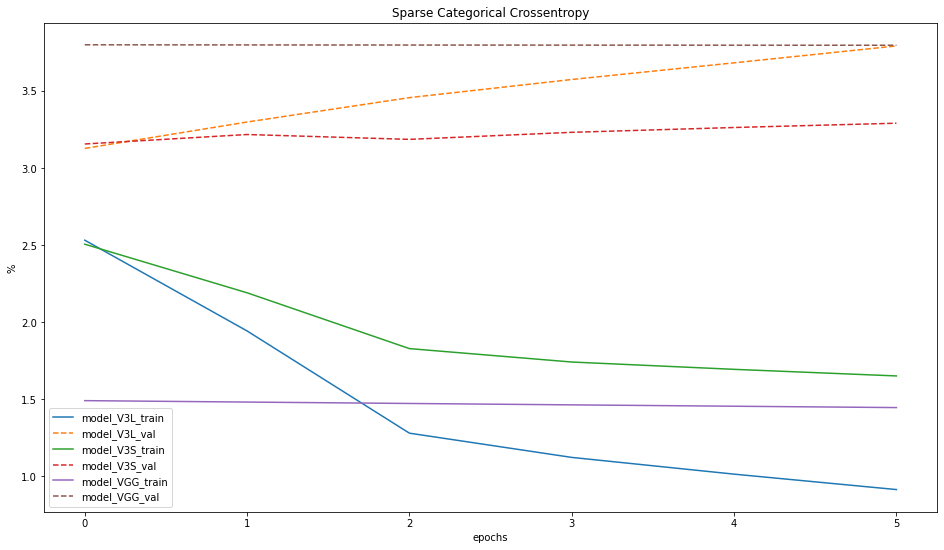

In [49]:
color_bar = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

plt.figure(figsize=(16,9))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond+"_train")
    plt.plot(range(len(results[cond]['val-acc'])),results[cond]['val-acc'], '--', label=cond+"_val")
plt.title("Sparse Categorical Crossentropy")
plt.xlabel("epochs")
plt.ylabel("%")
plt.legend()
plt.show()
# Best value at 0

## Evaluate performance on test set

In [50]:
loss_V3L, acc_V3L = model_V3L.evaluate(test_ds)

45/45 [==============================] - 22s 332ms/step - loss: 4.0760 - sparse_categorical_crossentropy: 4.0760


In [51]:
loss_V3S, acc_V3S = model_V3S.evaluate(test_ds)

45/45 [==============================] - 2s 36ms/step - loss: 3.4779 - sparse_categorical_crossentropy: 3.4779


In [52]:
loss_VGG, acc_VGG = model_VGG.evaluate(test_ds)

45/45 [==============================] - 15s 342ms/step - loss: 3.9456 - sparse_categorical_crossentropy: 3.9456


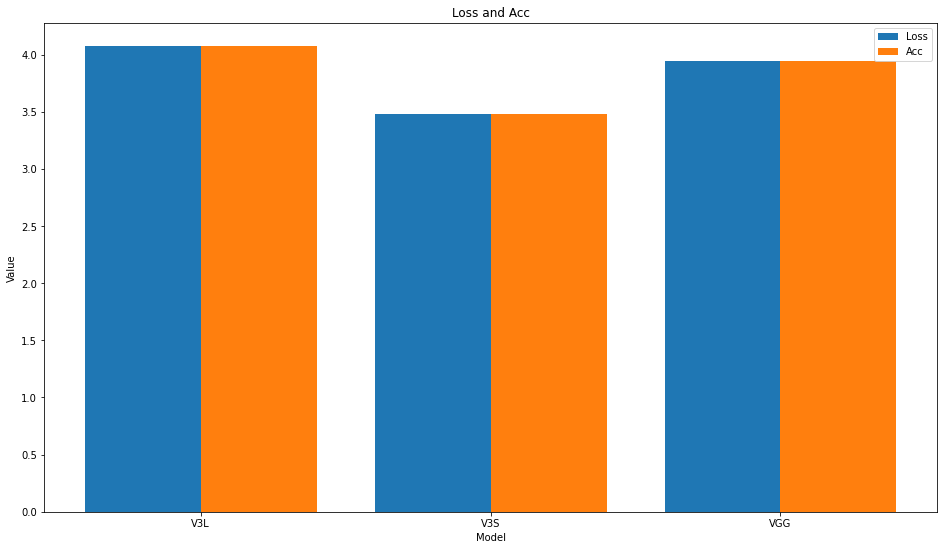

In [53]:
import matplotlib.pyplot as plt 
import numpy as np

X = ['V3L','V3S','VGG']
Loss = np.array( [ loss_V3L , loss_V3S , loss_VGG ] )
Acc = np.array( [ acc_V3L , acc_V3S , acc_VGG ] )

X_axis = np.arange(len(X))
plt.figure(figsize=(16,9))  

plt.bar(X_axis - 0.2, Loss, 0.4, label = 'Loss')
plt.bar(X_axis + 0.2, Acc, 0.4, label = 'Acc')
plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("Value")
plt.title("Loss and Acc")
plt.legend()
plt.show()
# Best value at 0

## Size of Model

In [54]:
import os
def getsize_model(file_path):
    size_byte = os.path.getsize(file_path)
    size_KB = size_byte / 1024
    size_MB = size_KB / 1024
    return size_MB

In [55]:
size_V3L = getsize_model(model_path/'MobileNetV3L.h5') 
size_V3S = getsize_model(model_path/'MobileNetV3S.h5') 
size_VGG = getsize_model(model_path/'VGGFace.h5') 

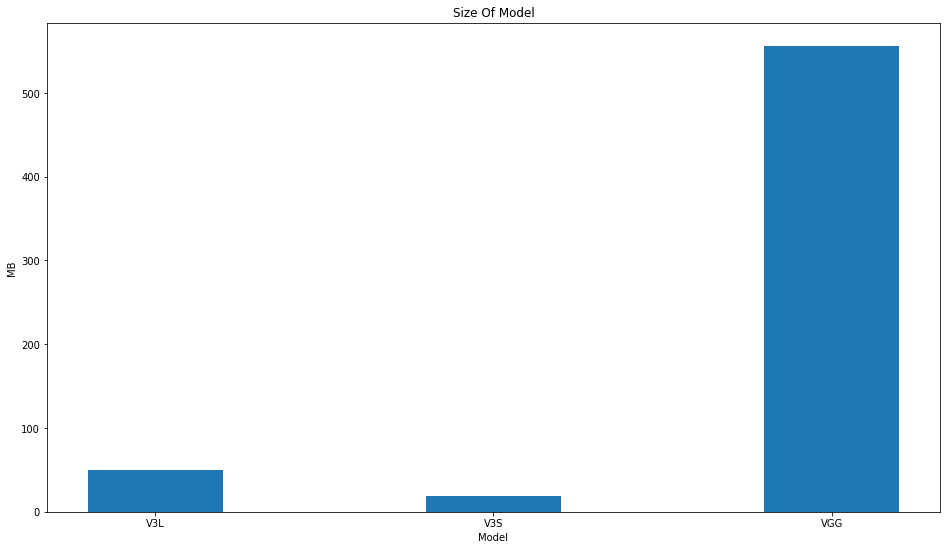

In [56]:
X = [ 'V3L' , 'V3S' , 'VGG' ]
Y = np.array ( [ size_V3L , size_V3S , size_VGG] )
X_axis = np.arange(len(X))
plt.figure(figsize=(16,9))  
plt.bar(X_axis , Y, 0.4)
plt.xticks(X_axis, X)
plt.xlabel("Model")
plt.ylabel("MB")
plt.title("Size Of Model")
plt.show()

# API

In [57]:
! pip install flask_cors

In [58]:
!pip install flask-ngrok

In [59]:
!pip install DeepFace

     |████████████████████████████████| 61kB 5.3MB/s 
     |████████████████████████████████| 2.3MB 21.9MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-3.13.0-cp37-none-any.whl size=9046 sha256=28dfb851f74193d19537311f395caf1168957d90dc158c65327313f25906155b
  Stored in directory: /root/.cache/pip/wheels/ba/fa/c5/12813d7496f34652c43a471e11a780e769889d06e34735c32e
Successfully built gdown
  Found existing installation: gdown 3.6.4
    Uninstalling gdown-3.6.4:
      Successfully uninstalled gdown-3.6.4


## Load Model

In [60]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
from deepface import DeepFace
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Directory  /root /.deepface created
Directory  /root /.deepface/weights created


In [67]:
model = load_model(model_path/'MobileNetV3L.h5')

## Predict Age

In [62]:
groups_names= ['Children', 'Teenage', 'Youth', 'Middle', 'Old']
age_dict = np.array([i for i in range(0, num_class)])
def predict_class(age):
    if age <= 10: return groups_names[0] #Children 0 - 10
    if age <= 18: return groups_names[1] #Teenage 10 - 18
    if age <= 34: return groups_names[2] #Youth   19 - 34
    if age <= 60: return groups_names[3] #Middle  35 - 60
    return groups_names[4]               #Old     61+
def preprocess_image(data):
    image = Image.fromarray(data, 'RGB')
    image = image.resize((224,224))
    image = np.array(image)
    image = np.expand_dims(image, axis = 0)
    return image
def detect_face(img_path):
    backends = ['opencv', 'ssd', 'dlib', 'mtcnn', 'retinaface']
    detected_face = DeepFace.detectFace( img_path , detector_backend=backends[2])
    return detected_face
def predict_age(image):
    input = preprocess_image(image)
    age_prediction = model.predict(input)
    age = np.sum(age_prediction * age_dict)
    return int(age), predict_class(age)

### Real test

Text(0.5, 1.0, 'Age: 45 - Middle')

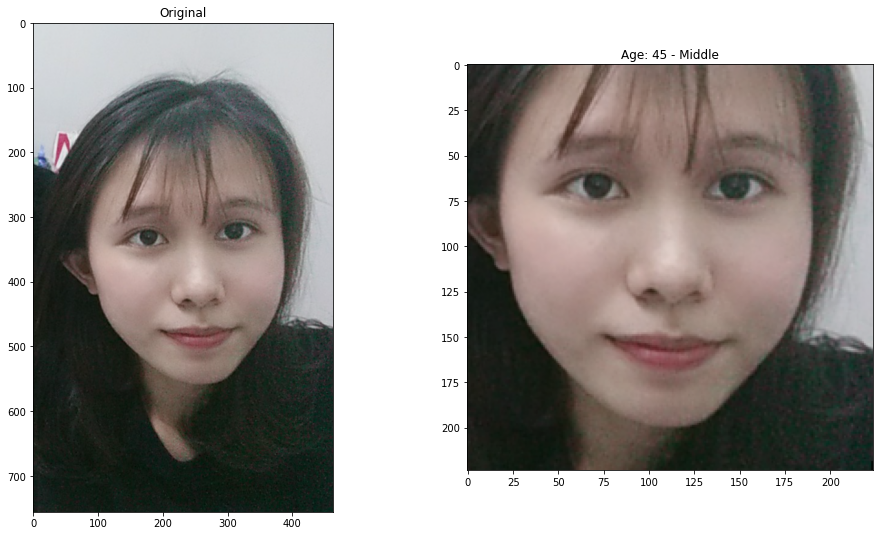

In [68]:
test = '/content/drive/MyDrive/FacialAge/Test_case/testcase2-18tuoi.png'
# test = '/content/drive/MyDrive/FacialAge/Test_case/testcase1-19tuoi.png'
# test = '/content/drive/MyDrive/FacialAge/Test_case/testcase4-21tuoi.png'
# test = '/content/drive/MyDrive/FacialAge/Test_case/testcase7-33tuoi.jpg'
# test = '/content/drive/MyDrive/FacialAge/Test_case/testcase8-33tuoi.jpg'
# test = '/content/drive/MyDrive/FacialAge/Test_case/test2.jpg'
detected_face = detect_face(test)
age, age_class = predict_age(detected_face)
text = 'Age: '+ str(age) + ' - '+ age_class

plt.figure(figsize=(16,9))
ax = plt.subplot(1, 2, 1)
plt.imshow(mpimg.imread(test))
plt.title('Original')
ax = plt.subplot(1, 2, 2)
plt.imshow(detected_face)
plt.title(text)